# Tarea 2 - MAN3160



**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.


En esta tarea, utilizaremos la librería Implicit vista en los tutoriales del curso para comparar el rendimiento de los modelos ALS y BPR.
Para realizar la tarea, deberán leer y ejecutar todas las celdas del notebook y completar/responder las actividades que serán dadas.

## Descarga del dataset

Al igual que en la tarea 1 y los tutoriales del curso, vamos a descargar el dataset [MovieLens-100k](https://grouplens.org/).

Podemos descargar el dataset directamente con el comando wget.

In [1]:
# !pip install wget
# !pip install zipfile36
# !pip3 install implicit --upgrade
# !python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [2]:
# import zipfile
# with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time

In [57]:
train_dir = "ml-100k/u3.base"
test_dir = "ml-100k/u3.test"

In [58]:
import pandas as pd

train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,6,5,887431973


In [59]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## Funciones

In [60]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [61]:
def evaluate_model(model, n):
    mean_map = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_map += mean_average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, n)

    mean_map /= len(user_items_test)
    mean_ndcg /= len(user_items_test)

    return mean_map, mean_ndcg

In [62]:
def show_recommendations(model, user, n):
    recommendations = model.recommend(userid=user_ids[user], user_items=user_item_matrix[user_ids[user]], N=n)
    return df_items.loc[recommendations[0]]['title']

# Actividades

### Actividad 1: Preparación del dataset

Prepare el dataset para que este pueda ser utilizado por los algoritmos de la librería Implicit. (Puede utilizar de base los tutoriales del curso), hasta generar la matriz user_items en formato csr. Puede importar/utilizar cualquier librería adicional que desée.

#### Respuesta:

Ingrese su respuesta en código a continuación. Puede utilizar todas las celdas de código que estime necesaria. Al finalizar, añada una celda de texto (Markdown en Jupyter) explicando qué contiene la matriz csr generada, qué representan sus columnas, sus filas y sus celdas internas.

In [63]:
# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
train_file.rating = [1 if x >= 3 else 0 for x in train_file.rating ]

In [64]:
train_file.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,3,1,878542960
3,1,4,1,876893119
4,1,6,1,887431973


In [65]:
# Cargamos el dataset de testing
test_file = pd.read_csv(test_dir,
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0)
test_file.rating = [1 if x >=3 else 0 for x in test_file.rating ]


user_items_test = {}

for row in test_file.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

In [66]:
user_items = {}
itemset = set()

for row in train_file.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []

    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

user_item_matrix = sparse.csr_matrix(sparse_matrix)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
items_ids = {key: i for i, key in enumerate(itemset)}

In [67]:
user_item_matrix.toarray()

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

La matriz generada `user_item_matrix` al solo hacer uso de las columnas userid y itemid,  genera una matriz dispersa en la que cada fila representa un usuario y cada columna representa un ítem. Los valores en la matriz indican si un usuario ha interactuado con un ítem específico. Si el valor en la posición **(i, j)** es *1*, significa que el usuario **i** ha interactuado con el ítem **j**, y si es *0*, significa que no ha habido interacción.

### Actividad 2: Entrenamiento de modelo ALS

Entrene el modelo ALS con el set de entrenamiento y realice un estudio de hiperparámetros sobre al menos 2 hiperparámetros del modelo. Despliegue el gráfico sobre la variación del rendimiento (en base a las métricas nDCG y MAP) según el valor del hiperparámetro y explique explícitamente la forma de los gráficos, las conclusiones obtenidas de ellos y la mejor combinación de hiperparámetros en su opinión. Registre y haga un gráfico del tiempo de entrenamiento de cada método. Se recomienda usar la librería _time_ para esto.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [15]:
%%time
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares()
model_als.fit(user_item_matrix)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 2.99 s, sys: 3.41 s, total: 6.41 s
Wall time: 559 ms


In [16]:
for n in [5, 10, 15, 20]:
    mmap, ndcg = evaluate_model(model_als, n)
    print(f'map@{n}: {mmap} \nndcg@{n}: {ndcg}')

map@5: 0.4801655798491231 
ndcg@5: 0.7537399309551208
map@10: 0.4504728056781243 
ndcg@10: 0.8653624856156502
map@15: 0.42295871706586224 
ndcg@15: 0.905638665132336
map@20: 0.39964008524790895 
ndcg@20: 0.9309551208285386


In [18]:
# Definir los valores de factores y regularización
factores = [i*5 for i in range(1, 15)]
reg_fac = [0.001, 0.01, 0.1]

map_f = []
ndcg_f = []

map_rg = []
ndcg_rg = []

# Listas para almacenar los tiempos de entrenamiento
tiempos_factores = []
tiempos_regularizacion = []

# Entrenar y medir el tiempo para diferentes valores de factores
for f in factores:
    model_als = implicit.als.AlternatingLeastSquares(factors=f)
    start_time = time.time()
    model_als.fit(user_item_matrix)
    end_time = time.time()
    tiempo_entrenamiento = end_time - start_time
    tiempos_factores.append(tiempo_entrenamiento)

    # Guardar metricas 
    mmap, ndcg = evaluate_model(model_als, 10)
    map_f.append(mmap)
    ndcg_f.append(ndcg)

# Entrenar y medir el tiempo para diferentes valores de regularización
for rg in reg_fac:
    model_als = implicit.als.AlternatingLeastSquares(regularization=rg)
    start_time = time.time()
    model_als.fit(user_item_matrix)
    end_time = time.time()
    tiempo_entrenamiento = end_time - start_time
    tiempos_regularizacion.append(tiempo_entrenamiento)

    # Guardar metricas
    mmap, ndcg = evaluate_model(model_als, 10)
    map_rg.append(mmap)
    ndcg_rg.append(ndcg)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

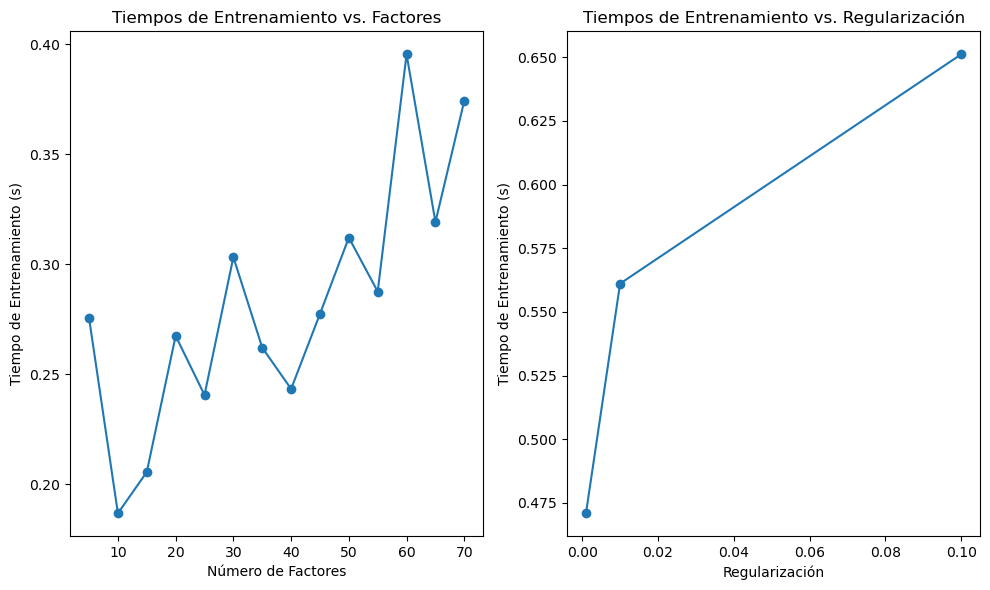

In [19]:
# Crear gráficos
plt.figure(figsize=(10, 6))

# Gráfico para tiempos de entrenamiento vs. factores
plt.subplot(1, 2, 1)
plt.plot(factores, tiempos_factores, marker='o')
plt.xlabel('Número de Factores')
plt.ylabel('Tiempo de Entrenamiento (s)')
plt.title('Tiempos de Entrenamiento vs. Factores')

# Gráfico para tiempos de entrenamiento vs. regularización
plt.subplot(1, 2, 2)
plt.plot(reg_fac, tiempos_regularizacion, marker='o')
plt.xlabel('Regularización')
plt.ylabel('Tiempo de Entrenamiento (s)')
plt.title('Tiempos de Entrenamiento vs. Regularización')

plt.tight_layout()
plt.show()

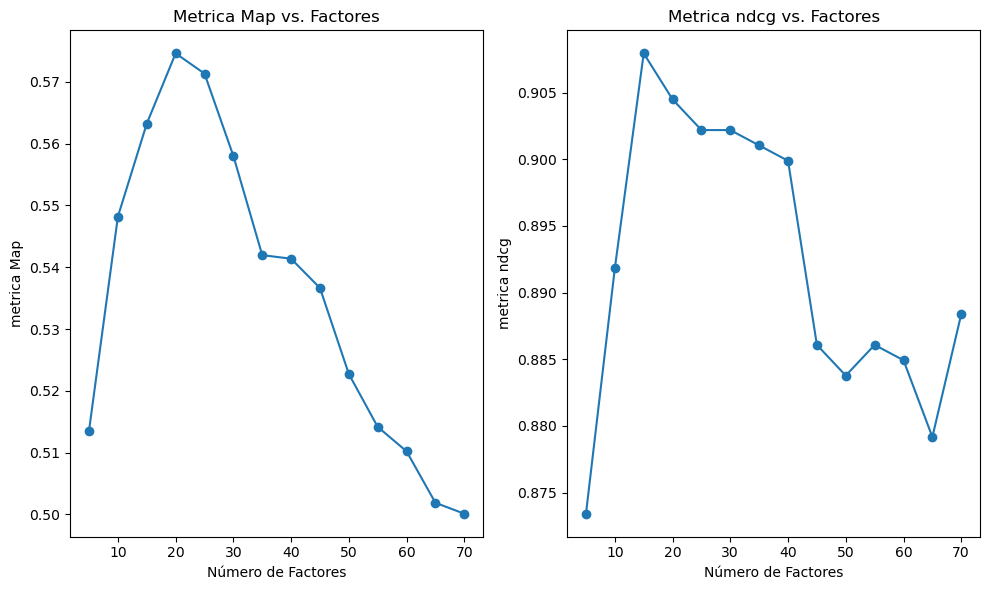

In [24]:
# Crear gráficos
plt.figure(figsize=(10, 6))

# Gráfico para metrica map vs. factores

plt.subplot(1, 2, 1)
plt.plot(factores, map_f, marker='o')
plt.xlabel('Número de Factores')
plt.ylabel('metrica Map')
plt.title('Metrica Map vs. Factores')

# Gráfico para tiempos de entrenamiento vs. regularización

plt.subplot(1, 2, 2)
plt.plot(factores, ndcg_f, marker='o')
plt.xlabel('Número de Factores')
plt.ylabel('metrica ndcg')
plt.title('Metrica ndcg vs. Factores')

plt.tight_layout()
plt.show()

De acuerdo con los resultados:

* Por un lado, se observa que los tres diferentes cambios sobre el hiperparametro de regularización, este cada vez tarda más ejecutarse, porque a medida que este creció, los tiempos aumentaron debido principalmente al factor estocastico de la iniciación del descenso del gradiente.

* Adicionalmente, si se observa que a medida que aumentó el número de factores latentes en la matríz de factores, desde el punto donde estos se encuentran entre **10 y 20 factores**, el modelo empieza a presentar metricas por mejorar, por lo cual, se recomendaría usar este rango para este modelo en particular de factores latentes, y permitirle al modelo no sobreajustarse a los datos de entrenamiento.

* Respecto al hiperparametro de regulación, a medida que este crece, el tiempo de ejecución aumenta. Debido al caracter estocastico del descenso del gradiente, pueda que para nuestro modelo lo mejor sea tener un hiperparametro de **0.01** pero esto va a depender netamente de la aletoriedad del modelo que se inicie.

### Actividad 3: Entrenamiento de modelo BPR

Repita el procedimiento de la Actividad 2 para el modelo BPR. Recuerde realizar un estudio de hiperparámetros sobre dos hiperparámetros distintos y exponer sus observaciones, elecciones como mejor combinación de hiperparámetros y realizar un análisis del tiempo de entrenamiento.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [25]:
model_bpr = implicit.bpr.BayesianPersonalizedRanking()
model_bpr.fit(user_item_matrix)

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
for n in [5, 10, 15, 20]:
    mmap, ndcg = evaluate_model(model_bpr, n)
    print(f'map@{n}: {mmap} \nndcg@{n}: {ndcg}')

map@5: 0.47509110088223944 
ndcg@5: 0.7077100115074798
map@10: 0.4466123312258032 
ndcg@10: 0.8319907940161104
map@15: 0.4204181568546316 
ndcg@15: 0.8883774453394706
map@20: 0.4005145430278297 
ndcg@20: 0.9079401611047181


In [27]:
# Definir los valores de factores y regularización
factores = [i*5 for i in range(1, 15)]
reg_fac = [0.001, 0.01, 0.1]

map_f = []
ndcg_f = []

map_rg = []
ndcg_rg = []

# Listas para almacenar los tiempos de entrenamiento
tiempos_factores = []
tiempos_regularizacion = []

# Entrenar y medir el tiempo para diferentes valores de factores
for f in factores:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f)
    start_time = time.time()
    model_bpr.fit(user_item_matrix)
    end_time = time.time()
    tiempo_entrenamiento = end_time - start_time
    tiempos_factores.append(tiempo_entrenamiento)

    # Guardar metricas 
    mmap, ndcg = evaluate_model(model_bpr, 10)
    map_f.append(mmap)
    ndcg_f.append(ndcg)

# Entrenar y medir el tiempo para diferentes valores de regularización
for rg in reg_fac:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(regularization=rg)
    start_time = time.time()
    model_bpr.fit(user_item_matrix)
    end_time = time.time()
    tiempo_entrenamiento = end_time - start_time
    tiempos_regularizacion.append(tiempo_entrenamiento)

    # Guardar metricas
    mmap, ndcg = evaluate_model(model_bpr, 10)
    map_rg.append(mmap)
    ndcg_rg.append(ndcg)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

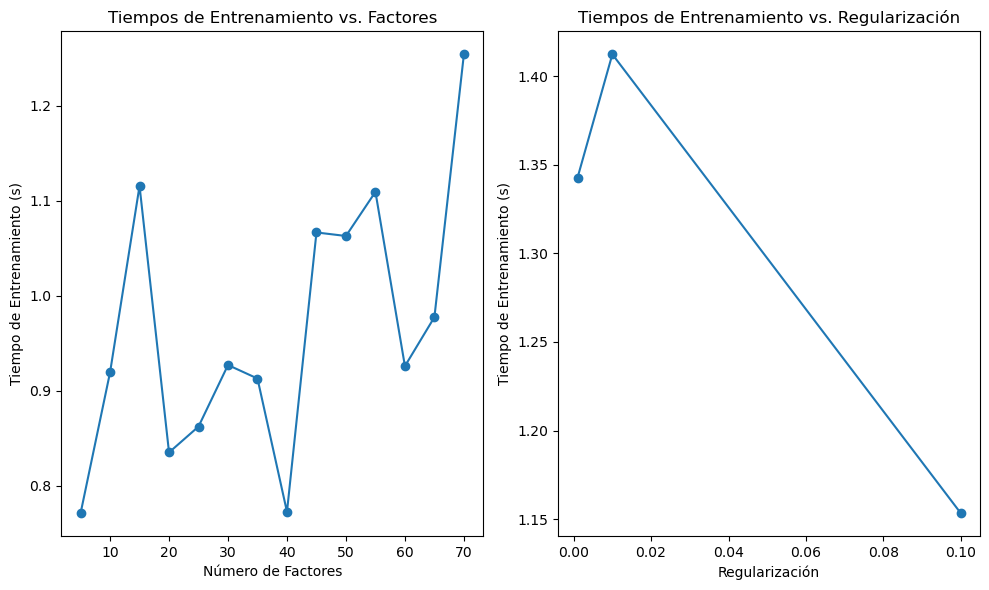

In [28]:
# Crear gráficos
plt.figure(figsize=(10, 6))

# Gráfico para tiempos de entrenamiento vs. factores
plt.subplot(1, 2, 1)
plt.plot(factores, tiempos_factores, marker='o')
plt.xlabel('Número de Factores')
plt.ylabel('Tiempo de Entrenamiento (s)')
plt.title('Tiempos de Entrenamiento vs. Factores')

# Gráfico para tiempos de entrenamiento vs. regularización
plt.subplot(1, 2, 2)
plt.plot(reg_fac, tiempos_regularizacion, marker='o')
plt.xlabel('Regularización')
plt.ylabel('Tiempo de Entrenamiento (s)')
plt.title('Tiempos de Entrenamiento vs. Regularización')

plt.tight_layout()
plt.show()

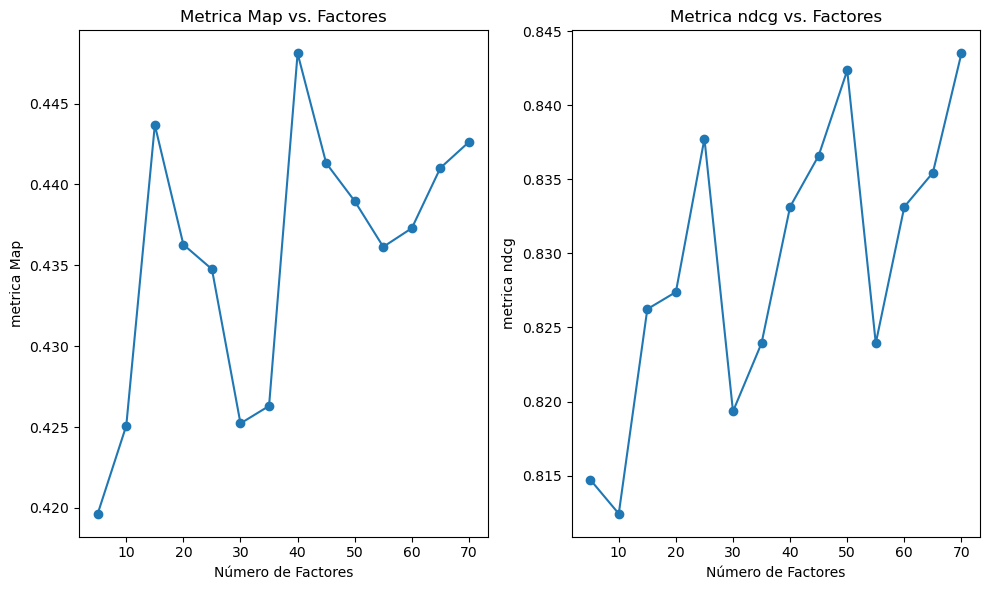

In [29]:
# Crear gráficos
plt.figure(figsize=(10, 6))

# Gráfico para metrica map vs. factores

plt.subplot(1, 2, 1)
plt.plot(factores, map_f, marker='o')
plt.xlabel('Número de Factores')
plt.ylabel('metrica Map')
plt.title('Metrica Map vs. Factores')

# Gráfico para tiempos de entrenamiento vs. regularización

plt.subplot(1, 2, 2)
plt.plot(factores, ndcg_f, marker='o')
plt.xlabel('Número de Factores')
plt.ylabel('metrica ndcg')
plt.title('Metrica ndcg vs. Factores')

plt.tight_layout()
plt.show()

De acuerdo con los resultados:

* Por un lado, se observa que los tres diferentes cambios sobre el hiperparametro de regularización, este cada vez tarda menos en ejecutarse, porque a medida que este creció, los tiempos disminuyeron debido principalmente al factor estocastico de la iniciación del descenso del gradiente.

* Adicionalmente, si se observa que a medida que aumentó el número de factores latentes en la matríz de factores, desde el punto donde estos se encuentran entre **10 y 20 factores**, el modelo mejorar pero muy ligeramente cambio de tiempo de ejecución mayor, por lo cual, se recomendaría usar este rango para este modelo en particular de factores latentes, y permitirle al modelo no sobreajustarse a los datos de entrenamiento.

* Respecto al hiperparametro de regulación, a medida que este crece, el tiempo de ejecución aumenta. Debido al caracter estocastico del descenso del gradiente, pueda que para nuestro modelo lo mejor sea tener un hiperparametro de **0.01** pero esto va a depender netamente de la aletoriedad del modelo que se inicie similar a como ocurrio con el modelo ALS.

### Actividad 4: Comparación de modelos.

Entrene modelos ALS y BPR con la combinación de hiperparámetros seleccionadas de las actividades 2 y 3. Genere una tabla exponiendo los resultados de ambos modelos al evaluarlos según nDCG@k y MAP@k proporcionadas (son libres de elegir el valor de k). Incluya también el valor del tiempo de entrenamiento empleado.

Además, implemente y agregue a su tabla los resultados usando una métrica adicional estudiada en el curso. Esta métrica puede ser programada por ustedes o usando una función de una librería externa.

Finalmente comente sobre los resultados de la tabla y concluya qué método entregó los mejores resultados para el set de datos utilizado.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

##### Metrica adicional - Precision at K

In [71]:
def evaluate_model(model, n):
    mean_map = 0.
    mean_ndcg = 0.
    mean_precision = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_map += mean_average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, n)
        mean_precision += precision_at_k(rel_vector, n)
        
    mean_map /= len(user_items_test)
    mean_ndcg /= len(user_items_test)
    mean_precision /= len(user_items_test)

    return mean_map, mean_ndcg, mean_precision

##### Modelo ALS

In [80]:
# Definir los valores de factores y regularización
factores = 20
reg_fac = 0.01

map = []
ndcg = []
precision = []

# Listas para almacenar los tiempos de entrenamiento
tiempo_eje = []

# Entrenamiento y medición del tiempo para modelo ALS
model_als_F = implicit.als.AlternatingLeastSquares(factors=factores, regularization=reg_fac)
start_time = time.time()
model_als_F.fit(user_item_matrix)
end_time = time.time()
tiempo_entrenamiento_ALS = end_time - start_time
tiempo_eje.append(tiempo_entrenamiento_ALS)

# Guardar metricas 
mmap_ALS, ndcg_ALS, precision_ALS = evaluate_model(model_als_F, 10)
map.append(mmap_ALS)
ndcg.append(ndcg_ALS)
precision.append(precision_ALS)

  0%|          | 0/15 [00:00<?, ?it/s]

##### Modelo BPR

In [81]:
# Entrenamiento y medición del tiempo para modelo BPR
model_bpr_F = implicit.bpr.BayesianPersonalizedRanking(factors=factores, regularization=reg_fac)
start_time = time.time()
model_bpr_F.fit(user_item_matrix)
end_time = time.time()
tiempo_entrenamiento_BPR = end_time - start_time
tiempo_eje.append(tiempo_entrenamiento_BPR)

# Guardar metricas 
mmap_BPR, ndcg_BPR, precision_BPR  = evaluate_model(model_bpr_F, 10)
map.append(mmap_BPR)
ndcg.append(ndcg_BPR)
precision.append(precision_BPR)

  0%|          | 0/100 [00:00<?, ?it/s]

In [86]:
data = [
    {"Modelos": ["Modelo ALS", "Modelo BPR"]},
    {"Metrica MAP": map},
    {"Metrica NDCG": ndcg},
    {"Metrica Precision at K":precision},
    {"Tiempo de Eje.": tiempo_eje}]

# Convertir la lista de diccionarios a un único diccionario
flat_dict = {}
for item in data:
    key = list(item.keys())[0]
    values = list(item.values())[0]
    flat_dict[key] = values
    
# Crear un DataFrame a partir de la lista de diccionarios
pd.DataFrame(flat_dict)

,Modelos,Metrica MAP,Metrica NDCG,Metrica Precision at K,Tiempo de Eje.
0,Modelo ALS,0.563870,0.904488,0.358458,0.206425
1,Modelo BPR,0.436175,0.834292,0.245109,0.819364


* En términos de las métricas MAP, NDCG y precision at K, el `Modelo ALS` ha logrado un rendimiento superior en comparación con el `Modelo BPR`. Esto sugiere que el Modelo ALS ha generado recomendaciones que tienden a estar más en línea con las preferencias de los usuarios y han logrado una mejor capacidad para capturar las relaciones relevantes entre usuarios e ítems.

* También es importante considerar el tiempo de ejecución promedio, donde el Modelo ALS tiene un tiempo significativamente menor en comparación con el Modelo BPR.

* Los resultados sugieren que el Modelo ALS ha logrado una mejor calidad en las recomendaciones generadas y menores tiempos, por tanto, para este caso sería el modelo aplicar.ción.

### Actividad 5: Comparación de modelos con modelo de feedback explícito.

Programe y evalúe un método de filtrado colaborativo de su elección sobre el mismo dataset. Evalúe este sistema y compare su rendimiento con los métodos de ALS y BPR entrenados en actividades anteriores. Recuerde que no todas las métricas son aplicables a sistemas de feedback explícito e implícito, por esto, seleccione al menos una métrica que permita realizar esta comparación. Justifique sus elecciones y concluya en base a los resultados dados.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.